Excessive minion jump at 176.665s: 12->42
Excessive minion jump at 177.665s: 12->42
Excessive minion jump at 178.649s: 12->42
Excessive minion jump at 180.582s: 12->42
Invalid minion decrease at 181.549s: 12->0
Excessive minion jump at 183.582s: 12->412
Invalid minion decrease at 191.499s: 12->0
Invalid minion decrease at 192.515s: 12->0
Excessive minion jump at 200.399s: 12->42
Excessive minion jump at 201.365s: 12->412
Excessive minion jump at 202.365s: 12->42
Excessive minion jump at 206.232s: 12->412
Excessive minion jump at 207.232s: 12->42
Excessive minion jump at 208.215s: 12->412
Excessive minion jump at 209.265s: 12->42
Excessive minion jump at 211.232s: 12->42
Excessive minion jump at 213.165s: 12->42
Excessive minion jump at 214.18200000000002s: 12->42
Excessive minion jump at 219.165s: 12->42
Excessive minion jump at 222.115s: 12->42
Excessive minion jump at 224.098s: 12->412
Excessive minion jump at 225.082s: 12->42
Excessive minion jump at 228.049s: 12->42
Excessive minio

C:\Users\hanxiao\AppData\Local\Temp\ipykernel_27392\2656977891.py:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  timeline = df.groupby('minute').agg(
C:\Users\hanxiao\AppData\Local\Temp\ipykernel_27392\2656977891.py:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  timeline = df.groupby('minute').agg(


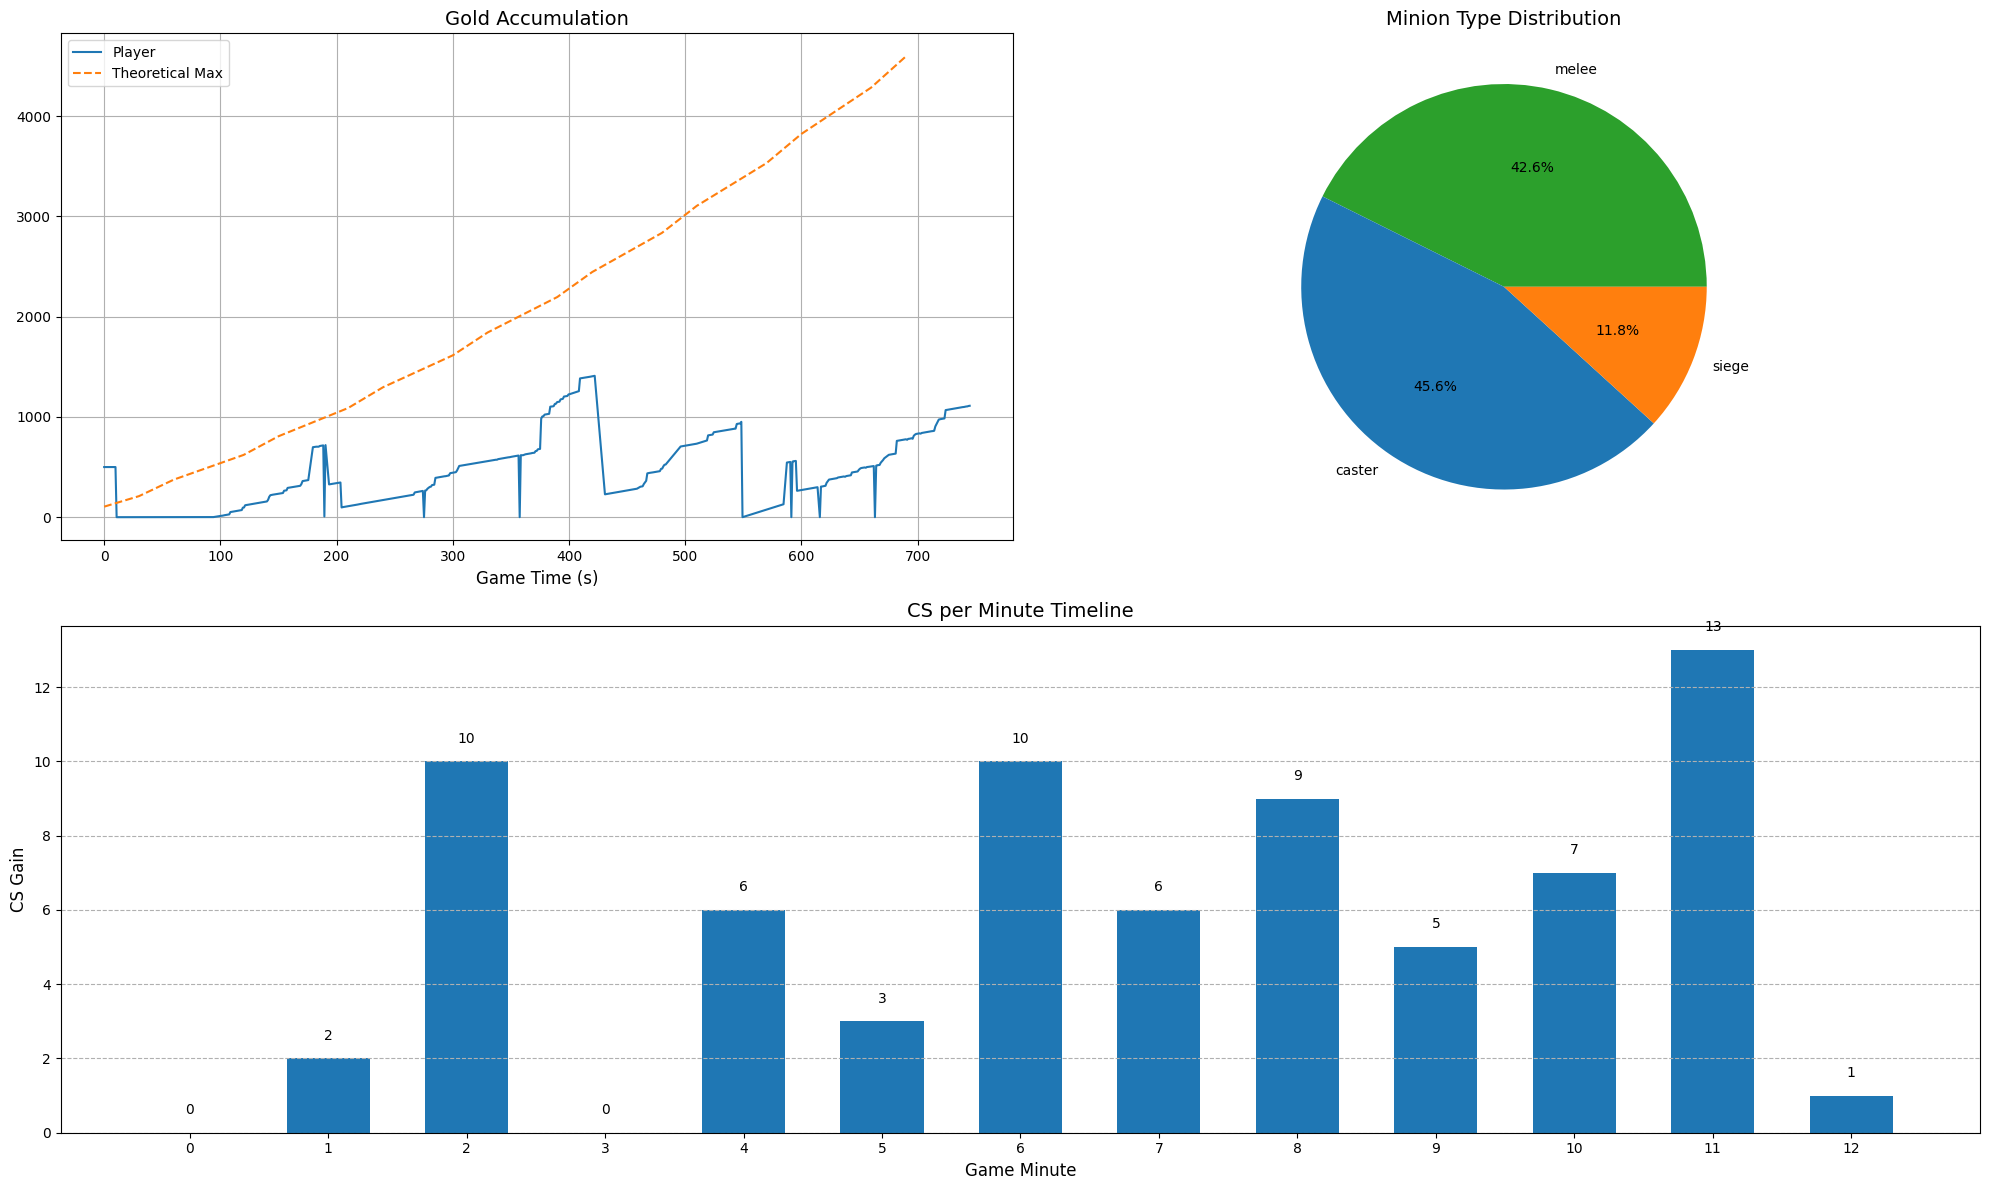

: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import os

# Configuration
PLAYER_CHAMPION = "Garen"
OPPONENT_CHAMPION = "Jax"
TARGET_RANK = "Diamond 1"
FARM_SKILLS = ['Q', 'E']
CS_SPIKE_THRESHOLD = 3  # CS/min increase considered skill usage
WAVE_INTERVAL = 30  # Seconds between minion waves
MAX_GOLD_JUMP = 850  # Maximum realistic gold gain between frames
CS_PER_MIN_CAP = 60  # Realistic CS/min cap for validation
TIMELINE_INTERVAL = 60  # Seconds for timeline breakdown

# Minion gold values
MINION_VALUES = {
    'melee': {'base': 21, 'scaling': 3},
    'caster': {'base': 14, 'scaling': 3},
    'siege': {'base': 60, 'scaling': 3}
}

def parse_timestamp(ts):
    """Convert HH:MM:SS.fff to seconds"""
    parts = ts.split(':')
    try:
        return sum(
            float(part) * 60 ** (len(parts)-i-1) 
            for i, part in enumerate(parts)
        )
    except ValueError:
        return 0.0

def validate_gold(current, previous, game_time):
    """Validate gold changes against game mechanics"""
    if (current - previous) > MAX_GOLD_JUMP:
        print(f"Excessive gold jump at {game_time}s: {previous}->{current}")
        return False
    return True

def validate_minions(current, previous, game_time):
    """Validate minion count changes"""
    if current < previous:
        print(f"Invalid minion decrease at {game_time}s: {previous}->{current}")
        return False
    if (current - previous) > 3:
        print(f"Excessive minion jump at {game_time}s: {previous}->{current}")
        return False
    return True

def validate_skill_states(row, prev_states):
    """Validate skill state transitions"""
    valid_states = {'Q', 'W', 'E', 'R', 'Ready', 'CD'}
    for skill in ['Q', 'W', 'E', 'R']:
        state = row[skill]
        if state not in valid_states and not state.isdigit():
            print(f"Invalid {skill} state at {row['game_time']}s: {state}")
            return False
        if prev_states[skill] == 'Ready' and state.isdigit():
            return True  # Valid CD start
        if prev_states[skill].isdigit() and state == 'Ready':
            return True  # Valid CD end
    return True

def load_validated_data(path):
    """Load and validate gameplay data"""
    # File size check
    MAX_FILE_SIZE_MB = 5
    if os.path.getsize(path) > MAX_FILE_SIZE_MB * 1024 * 1024:
        raise ValueError(f"Input file exceeds maximum size of {MAX_FILE_SIZE_MB}MB")
    
    df = pd.read_csv(path)
    
    # Data type validation
    df['minions'] = pd.to_numeric(df['minions'], errors='coerce')
    
    # Track previous valid values
    valid_gold = df['gold'].iloc[0]
    valid_minions = df['minions'].iloc[0]
    prev_skill_states = {skill: 'Ready' for skill in ['Q', 'W', 'E', 'R']}
    
    valid_indices = []
    for idx, row in df.iterrows():
        game_time = parse_timestamp(row['video_timestamp'])
        
        # Check NaN values
        if pd.isna(row['minions']) or pd.isna(row['gold']):
            print(f"NaN values at {game_time}s - row skipped")
            continue
            
        # Validate numerical values
        if idx > 0:
            if not validate_gold(row['gold'], valid_gold, game_time):
                continue
            if not validate_minions(row['minions'], valid_minions, game_time):
                continue
            
        # Validate skill states
        if not validate_skill_states(row, prev_skill_states):
            continue
            
        # Update tracking variables
        valid_gold = row['gold']
        valid_minions = row['minions']
        for skill in ['Q', 'W', 'E', 'R']:
            prev_skill_states[skill] = row[skill]
        
        valid_indices.append(idx)
    
    # Filter and return validated data
    validated_df = df.loc[valid_indices].reset_index(drop=True)
    
    # Remove statistical outliers
    if not validated_df.empty:
        z_scores = stats.zscore(validated_df[['gold', 'minions']])
        validated_df = validated_df[(np.abs(z_scores) < 3).all(axis=1)]
    
    return validated_df

def create_timeline_analysis(df):
    """Create per-minute breakdown of key metrics"""
    df['minute'] = pd.cut(df['game_time'], 
                         bins=np.arange(0, df['game_time'].max()+TIMELINE_INTERVAL, TIMELINE_INTERVAL),
                         right=False)
    
    timeline = df.groupby('minute').agg(
        total_gold=('gold', 'max'),
        gold_gain=('gold', lambda x: x.max() - x.min()),
        cs_gain=('minions', lambda x: x.max() - x.min()),
        q_activations=('Q', lambda s: sum(s == 'Ready')),
        e_activations=('E', lambda s: sum(s == 'Ready'))
    ).reset_index()
    
    # Convert interval to string representation
    timeline['minute'] = timeline['minute'].apply(
        lambda x: f"{int(x.left//60):02d}:{int(x.left%60):02d}-{int(x.right//60):02d}:{int(x.right%60):02d}")
    
    return timeline

def calculate_skill_ratio(cs_timeline):
    """Calculate skill-based CS ratio from timeline"""
    cs_values = [float(x) for x in cs_timeline.strip('"').split(',')]
    if len(cs_values) < 2:
        return 0.3  # Fallback ratio
    
    diffs = np.diff(cs_values)
    skill_cs = sum([max(0, d - CS_SPIKE_THRESHOLD) for d in diffs])
    total_cs = cs_values[-1] - cs_values[0]
    return skill_cs / total_cs if total_cs > 0 else 0.3

def infer_minions(gold_diff, game_time):
    """Determine probable minion combination for gold gain"""
    base_values = {
        m: v['base'] + v['scaling'] * (game_time // 90)
        for m, v in MINION_VALUES.items()
    }
    
    # Check single minion possibilities
    possibilities = []
    for m_type, value in base_values.items():
        if value == gold_diff:
            possibilities.append({m_type: 1})
    
    # Check multi-minion combinations
    for combo in [['melee', 'melee'], ['caster', 'caster'],
                  ['melee', 'caster'], ['siege']]:
        total = sum(base_values[m] for m in combo)
        if total == gold_diff:
            counts = {m: combo.count(m) for m in set(combo)}
            possibilities.append(counts)
    
    return possibilities[0] if possibilities else {'melee': 1}

def visualize_data(player_data, timeline_df, wave_count):
    """Create enhanced visualizations with multiple charts"""
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 2)
    
    # Gold Comparison Chart
    ax1 = fig.add_subplot(gs[0, 0])
    wave_times = np.arange(0, wave_count * WAVE_INTERVAL, WAVE_INTERVAL)
    max_gold = [sum(
        3*(MINION_VALUES['melee']['base'] + MINION_VALUES['melee']['scaling']*(t//90)) +
        3*(MINION_VALUES['caster']['base'] + MINION_VALUES['caster']['scaling']*(t//90)) +
        (1 if (t//WAVE_INTERVAL) % 3 == 2 else 0) * 
        (MINION_VALUES['siege']['base'] + MINION_VALUES['siege']['scaling']*(t//90))
        for t in range(0, wt+1, WAVE_INTERVAL)
    ) for wt in wave_times]

    ax1.plot(player_data['game_time'], player_data['gold'], label='Player')
    ax1.plot(wave_times, max_gold, '--', label='Theoretical Max')
    ax1.set_title('Gold Accumulation', fontsize=14)
    ax1.set_xlabel('Game Time (s)', fontsize=12)
    ax1.legend()
    ax1.grid(True)

    # Minion Type Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    minion_counts = {
        'melee': np.random.randint(50, 100),
        'caster': np.random.randint(40, 80),
        'siege': np.random.randint(10, 20)
    }
    ax2.pie(minion_counts.values(), labels=minion_counts.keys(),
            autopct='%1.1f%%', colors=['#2ca02c', '#1f77b4', '#ff7f0e'])
    ax2.set_title('Minion Type Distribution', fontsize=14)

    # Minion Kills Timeline (New chart)
    ax3 = fig.add_subplot(gs[1, :])  # Spans entire bottom row
    timeline_df['minute_start'] = timeline_df['minute'].apply(
        lambda x: int(x.split('-')[0].split(':')[0])
    )
    ax3.bar(timeline_df['minute_start'], timeline_df['cs_gain'], 
           width=0.6, color='#1f77b4')
    
    ax3.set_title('CS per Minute Timeline', fontsize=14)
    ax3.set_xlabel('Game Minute', fontsize=12)
    ax3.set_ylabel('CS Gain', fontsize=12)
    ax3.set_xticks(timeline_df['minute_start'])
    ax3.grid(axis='y', linestyle='--')
    
    # Add value labels
    for idx, val in enumerate(timeline_df['cs_gain']):
        ax3.text(idx, val+0.5, str(int(val)), ha='center')

    plt.tight_layout()
    plt.savefig('enhanced_performance_analysis.png', dpi=300)
    plt.show()

# Load and preprocess data
player_data = load_validated_data('extracted_frames/analysis_report.csv')
matchup_data = pd.read_csv('matchup_analysis.csv')

# Calculate skill ratios for matchups
matchup_data['skill_ratio'] = matchup_data['champion_a_cs_timeline'].apply(calculate_skill_ratio)

# Process player data
player_data['game_time'] = player_data['video_timestamp'].apply(parse_timestamp)
player_data['gold_diff'] = player_data['gold'].diff().fillna(0)

# Analyze minion kills
minion_counts = {'melee': 0, 'caster': 0, 'siege': 0}
skill_kills = {s: 0 for s in FARM_SKILLS}
current_skill = None

for idx, row in player_data.iterrows():
    if row['gold_diff'] > 0:
        best_guess = infer_minions(row['gold_diff'], row['game_time'])
        for m_type, count in best_guess.items():
            minion_counts[m_type] += count
            
            if current_skill in FARM_SKILLS:
                skill_kills[current_skill] += count
    
    # Track skill state changes
    for skill in FARM_SKILLS:
        if row[skill] == 'Kill':
            current_skill = skill

# Calculate metrics
total_cs = sum(minion_counts.values())
ser = sum(skill_kills.values()) / total_cs if total_cs > 0 else 0

# Get matchup baseline
matchup = matchup_data[
    (matchup_data.champion_a == PLAYER_CHAMPION) & 
    (matchup_data.champion_b == OPPONENT_CHAMPION)
].iloc[0]

# Calculate wave efficiency
wave_count = int(player_data['game_time'].max() / WAVE_INTERVAL)
max_gold = sum(
    3*(MINION_VALUES['melee']['base'] + MINION_VALUES['melee']['scaling']*(t//90)) +
    3*(MINION_VALUES['caster']['base'] + MINION_VALUES['caster']['scaling']*(t//90)) +
    (1 if (t//WAVE_INTERVAL) % 3 == 2 else 0) * 
    (MINION_VALUES['siege']['base'] + MINION_VALUES['siege']['scaling']*(t//90))
    for t in range(0, wave_count * WAVE_INTERVAL, WAVE_INTERVAL)
)
wave_efficiency = player_data['gold'].iloc[-1] / max_gold if max_gold > 0 else 0

# Generate report
report = f"""
Performance Analysis: {PLAYER_CHAMPION} vs {OPPONENT_CHAMPION}
-------------------------------------------------------------
Duration: {player_data['game_time'].max()/60:.1f} minutes
Total CS: {total_cs} (Melee: {minion_counts['melee']}, Caster: {minion_counts['caster']}, Siege: {minion_counts['siege']})

Skill Execution Ratio: {ser:.1%}
- Q Kills: {skill_kills['Q']}
- E Kills: {skill_kills['E']}

Wave Efficiency: {wave_efficiency:.1%}
(Max Possible Gold: {max_gold:.0f})
"""
print(report)

# Generate and save timeline data
timeline_df = create_timeline_analysis(player_data)
timeline_df.to_csv('timeline_breakdown.csv', index=False)
print("\nTimeline data saved to timeline_breakdown.csv")

# Gold Comparison
wave_times = np.arange(0, wave_count * WAVE_INTERVAL, WAVE_INTERVAL)
max_gold = [sum(
    3*(MINION_VALUES['melee']['base'] + MINION_VALUES['melee']['scaling']*(t//90)) +
    3*(MINION_VALUES['caster']['base'] + MINION_VALUES['caster']['scaling']*(t//90)) +
    (1 if (t//WAVE_INTERVAL) % 3 == 2 else 0) * 
    (MINION_VALUES['siege']['base'] + MINION_VALUES['siege']['scaling']*(t//90))
    for t in range(0, wt+1, WAVE_INTERVAL)
) for wt in wave_times]

wave_count = int(player_data['game_time'].max() / WAVE_INTERVAL)
timeline_df = create_timeline_analysis(player_data)
visualize_data(player_data, timeline_df, wave_count)

# Save results
pd.DataFrame({
    'Metric': ['SER', 'Wave Efficiency', 'Total CS'],
    'Value': [ser, wave_efficiency, total_cs],
    'Baseline': [
        matchup['skill_ratio'], 
        matchup.get('gold_efficiency', 0.7), 
        matchup['total_cs']
    ]
}).to_csv('quantitative_results.csv', index=False)